In [ ]:
import pandas as pd
from globals import BASE_DIR, available_datasets
import json
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

import folium
from folium.plugins import MarkerCluster


#available_datasets =["foursquaretky"]


## Descriptive Statistics & Dataset Sample Overview


This notebook needs to be run after data_sampling.py (or only with foursquaretky in the available_datasets)

In [3]:
def group_user_events(user_events, user_groups):
    """ Return statistics of user events for each group of users."""
    stats = {}
    for group in user_groups.keys():
        stats[group] = {}
        user_events_group = user_events.copy()
        user_events_group = user_events_group.loc[user_events_group["user_id:token"].isin(user_groups[group])]
        user_dist = user_events_group["user_id:token"].value_counts()
        stats[group]["num_users"] = user_dist.shape[0]
        stats[group]["mean_checkins"] = user_events_group["user_id:token"].value_counts().mean()
        stats[group]["min_checkins"] = user_events_group["user_id:token"].value_counts().min()
        stats[group]["max_checkins"] = user_events_group["user_id:token"].value_counts().max()
        item_dist = user_events_group["item_id:token"].value_counts()
        stats[group]["num_items"] = item_dist.shape[0]
        stats[group]["num_checkins"] = user_events_group.shape[0]
        stats[group]["sparsity"] = 1 - len(user_events_group) / (len(user_events_group["user_id:token"].unique()) * len(user_events_group["item_id:token"].unique()))

    return stats



In [4]:
def plot_item_distr(user_events, dataset):
    user_events["item_id:token"].astype(str).value_counts().plot(
        figsize=(12, 6), linestyle='-', label=dataset  # <-- label here
    )
    plt.xlabel('POI', fontsize=20)
    plt.title(f'Long tail of POI check-ins ({dataset.capitalize()})', fontsize=20)
    plt.ylabel('Number of Check-Ins', fontsize=20)
    plt.grid(True)
    plt.xticks([])
    plt.yticks(fontsize=16)

    # Save plot
    #plt.savefig(f'{DATASET_DIR}/plots/Number of Check-Ins by POI ({dataset})', dpi=300)
    plt.show()

## Descriptive Statistics & Plotting Item Distribution

Dataset: foursquaretky, Number of unique check-ins in the dataset: 69401


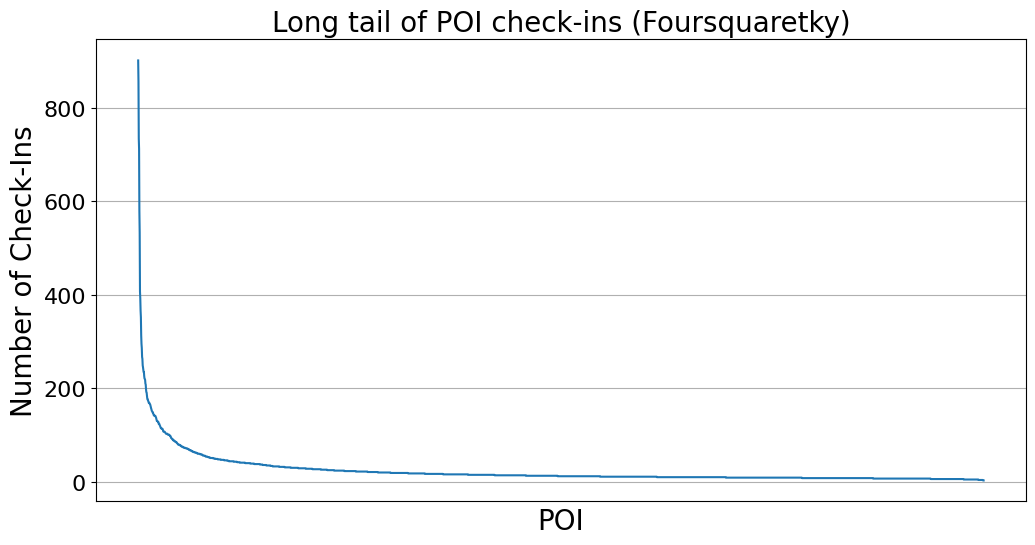

dataset:  foursquaretky
Mean (different) POI check-ins per User:  46.26733333333333
Min (different) POI check-ins per User:  15
Max (different) POI check-ins per User:  271
Number of users:  1500
Number of POIs (items):  2804
Sparsity: 0.9834995244888255


In [5]:
full_stats = {}
for dataset in available_datasets:
    DATASET_DIR = f"{BASE_DIR}{dataset}_dataset/"
    # Stays the same across all models 
    train_data = pd.read_csv(f"{BASE_DIR}{dataset}_dataset/processed_data_recbole/{dataset}_sample.train.inter", sep="\t")
    test_data = pd.read_csv(f"{BASE_DIR}{dataset}_dataset/processed_data_recbole/{dataset}_sample.test.inter", sep="\t")
    valid_data = pd.read_csv(f"{BASE_DIR}{dataset}_dataset/processed_data_recbole/{dataset}_sample.valid.inter", sep="\t")

    user_group_dir = f"{BASE_DIR}{dataset}_dataset/{dataset}_user_id_popularity.json"
    with open(user_group_dir) as f:
        user_groups = json.load(f)


    all_user_ids = (
    set(user_groups["high"])
    | set(user_groups["medium"])
    | set(user_groups["low"])
    )
    user_groups["all"] = list(all_user_ids)
    user_events = pd.concat([train_data, valid_data, test_data])
    user_events = user_events.drop_duplicates(subset=["user_id:token", "item_id:token"])
    print(f"Dataset: {dataset}, Number of unique check-ins in the dataset: {user_events.shape[0]}")
    full_stats[dataset] = group_user_events(user_events, user_groups)

    plot_item_distr(user_events, dataset)



    user_dist = user_events["user_id:token"].value_counts()
    num_users = user_dist.shape[0]
    print("dataset: ", dataset)
    print("Mean (different) POI check-ins per User: ", user_events["user_id:token"].value_counts().mean())
    print("Min (different) POI check-ins per User: ", user_events["user_id:token"].value_counts().min())
    print("Max (different) POI check-ins per User: ", user_events["user_id:token"].value_counts().max())
    print("Number of users: ", num_users)

    # item distribution
    item_dist = user_events["item_id:token"].value_counts()
    num_items = item_dist.shape[0]
    print("Number of POIs (items): ", num_items)

    # sparsity
    print("Sparsity:", 1 - len(user_events) / (len(user_events["user_id:token"].unique()) * len(user_events["item_id:token"].unique())))

long_format_df = []

for dataset, group_stats in full_stats.items():
    for group, metrics in group_stats.items():
        row = {"dataset": dataset, "group": group}
        row.update(metrics)
        long_format_df.append(row)


long_format_df = pd.DataFrame(long_format_df)

In [6]:
long_format_df


dataset   group  num_users  mean_checkins  min_checkins  \
0  foursquaretky    high        300      32.340000            15   
1  foursquaretky  medium        900      53.182222            15   
2  foursquaretky     low        300      39.450000            15   
3  foursquaretky     all       1500      46.267333            15   

   max_checkins  num_items  num_checkins  sparsity  
0            69       1992          9702  0.983765  
1           168       2803         47864  0.981027  
2           271       2608         11835  0.984873  
3           271       2804         69401  0.983500

In [7]:
stats_all_users = long_format_df.loc[long_format_df["group"] == "all"]
#stats_all_users.to_csv(f"{BASE_DIR}/descriptive_stats.csv", index=False)

## POI Overwiew Map

The following map shows the coordinates and POI-clusters for each dataset sample in the available datasets. Each dataset is displayed in a different color.


In [8]:
colors = ['blue', 'green', 'orange', 'purple']

map_center = [39.95, -75.16] 
poi_map = folium.Map(location=map_center, zoom_start=5)

for dataset, color in zip(available_datasets, colors):
    file_path = DATASET_DIR = f"{BASE_DIR}{dataset}_dataset/processed_data_capri/poiCoos.txt"
    poi_data = pd.read_csv(file_path, sep="\t", header=None, names=["id", "lat:float", "lon:float"])
    

    marker_cluster = MarkerCluster(name=dataset).add_to(poi_map)
    
    for _, row in poi_data.iterrows():
        folium.CircleMarker(
            location=[row["lat:float"], row["lon:float"]],
            radius=5,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.7,
            popup=f"ID: {row['id']}, Dataset: {dataset}"
        ).add_to(marker_cluster)

folium.LayerControl().add_to(poi_map)
#poi_map.save("poi_map.html")
poi_map




